In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Набор данных описывает ежемесячный подсчет количества наблюдаемых солнечных пятен за чуть более 230 лет (1749-1983). Набор данных показывает сезонность с большими различиями между сезонами.

In [3]:
data_train = pd.read_csv("monthly-sunspots.csv", index_col = 'Month')
data_train.head()

,Sunspots
Month,
1749-01,58.0
1749-02,62.6
1749-03,70.0
1749-04,55.7
1749-05,85.0


In [4]:
data_train = data_train['Sunspots']
data_train = data_train[0:300]

### Постройте график полученного ряда (ВР).

<AxesSubplot:xlabel='Month'>

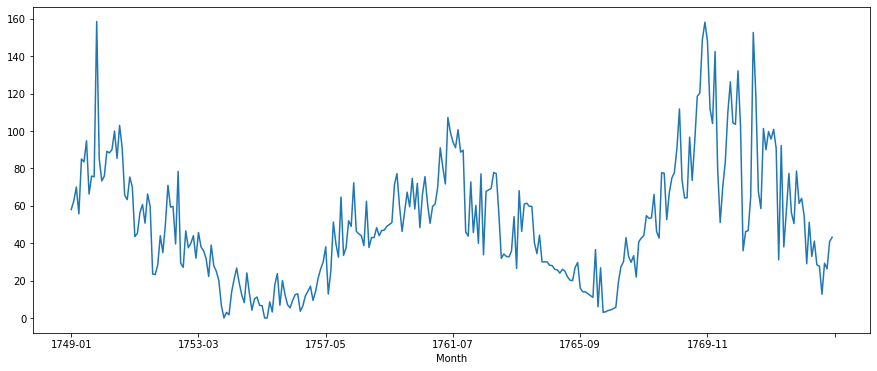

In [5]:
data_train.plot(figsize=(15,6))

### Осуществите проверку на случайность полученного ряда по обоим известным вам критериям.

Критерий серий, основанный на медиане выборки

In [6]:
median = data_train.median()
def plus_minus_median(row):
    if row > median:
        return '+'
    elif row < median:
        return '-'
    else:
        return '0'

In [7]:

def series_test(df):
    n = len(df)
    median = df.median()
    y_plus_minus = df.apply(plus_minus_median).values
    series = []
    max_series = 0
    k = 1
    for i in range(1,n):
        if (y_plus_minus[i] != y_plus_minus[i-1]):
            
            if k > 0:
                series.append(k)
                if k > max_series:
                    max_series = k
            if (y_plus_minus[i] == '0'):
                k = 0
            else:
                k = 1
        else:
            k += 1
    first_cond = len(series) > 0.5 * (n + 1 - 1.96 * (n-1)**(1/2))
    second_cond = max_series < 3.3 * np.log(n+1)
    return first_cond, second_cond

In [8]:
series_test(data_train)

(False, False)

**Вывод:** Ни одно из условий не выполняются,  следовательно отклоняем гипотезу случайности, значит данные не случайны, присутстует тренд.

Критерий "восходящих и нисходящих" серий

In [9]:
def plus_minus_zero(row):
    if row > 0:
        return '+'
    elif row < 0:
        return '-'
    else:
        return '0'
    
def tay_0(n):
    if n <= 26:
        return 5
    elif 26 < n <= 153:
        return 6
    elif 153 < n <= 1170:
        return 7
    else:
        print('n out of 1170!')
        return 7

In [10]:
def second_test(df):
    df_diff = df.diff()
    
    y_plus_minus = df_diff.apply(plus_minus_zero).values
    series = []
    max_series = 0
    k = 1
    n = len(y_plus_minus)
    for i in range(1,n):
        if (y_plus_minus[i] != y_plus_minus[i-1]):
            
            if k > 0:
                series.append(k)
                if k > max_series:
                    max_series = k
            if (y_plus_minus[i] == '0'):
                k = 0
            else:
                k = 1
        else:
            k += 1
            
    firs_cond = len(series) > (1/3)*(2*n - 1) - 1.96*((16*n-29)/90)**(1/2)
    second_cond = max_series < tay_0(n)
    return firs_cond, second_cond

In [11]:
second_test(data_train)

(False, False)

**Вывод:** Ни одно из условый не выполняются,  следовательно отклоняем гипотезу случайности, значит данные не случайны, присутстует тренд.

### Получите статистическую оценку тренда и сезонной компоненты ВР с помощью МНК. Сравните полученную оценку тренда с трендом.

<AxesSubplot:xlabel='Month'>

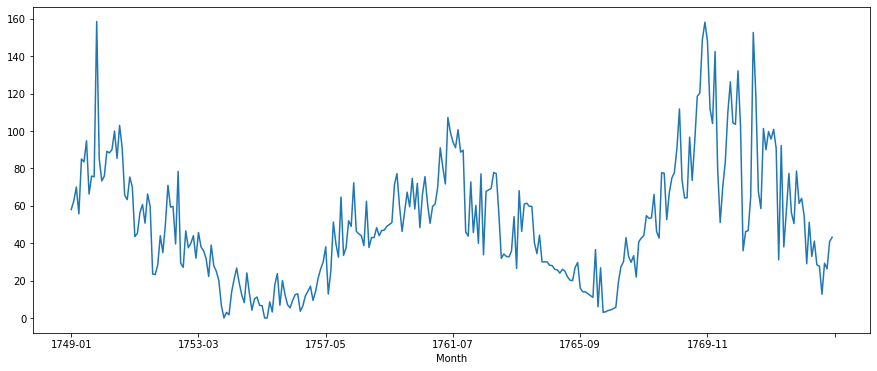

In [12]:
data_train.plot(figsize=(15,6))

**Построим парную линейную регрессию**

In [13]:
y = data_train.values

In [14]:
X = np.arange(1, len(y)+1)[:, np.newaxis]

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
regr = LinearRegression()

In [17]:
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

In [18]:
regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

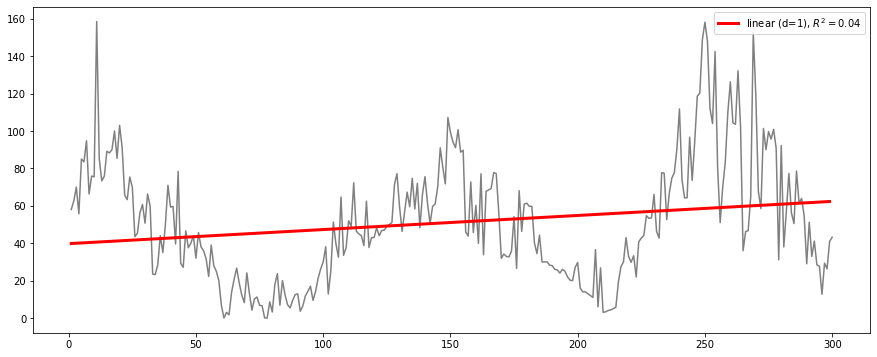

In [19]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_fit, y_lin_fit, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=1), $R^2={:.2f}$'.format(linear_r2))

plt.legend(loc = 'upper right')

**Посторим полиномиальную регрессию**

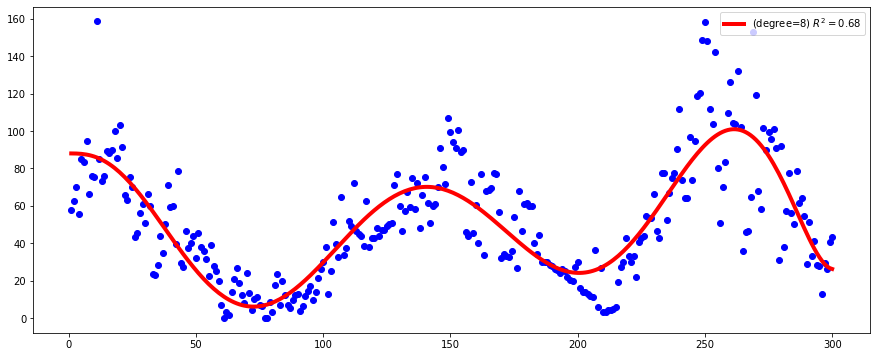

In [20]:

X_fit = X
quadratic = PolynomialFeatures(degree = 8)
X_quad = quadratic.fit_transform(X)
regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quad_r2 = r2_score(y, regr.predict(X_quad))
MAE = mean_absolute_error(y, y_quad_fit)

plt.figure(figsize=(15,6))
plt.scatter(X, y, color = 'b')
plt.plot(X_fit, y_quad_fit,
        color = 'red',
        lw = 4,
        linestyle = '-',
        label = '(degree=8) $R^2={:.2f}$'.format(quad_r2))
plt.legend(loc = 'upper right')

In [22]:
X_OLS_trend = X_fit
y_OLS_trend = y_quad_fit

### Оцените тренд и сезонную компоненту, не используя аналитические предположения о виде сезонной компоненты.

Отсюда следует ПЛР со стахостическим градиентным спуском

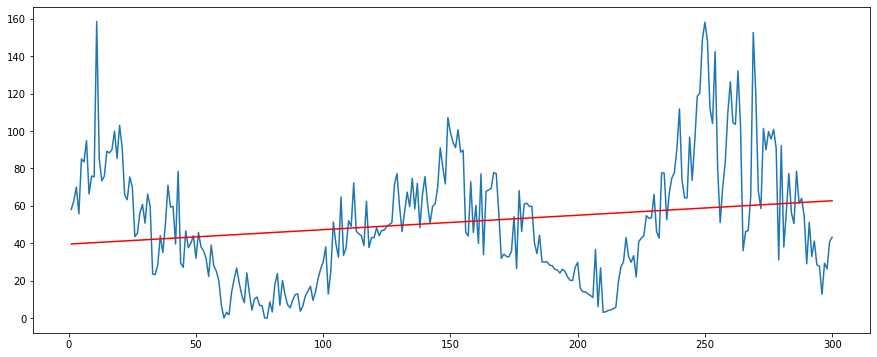

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
model = SGDRegressor()
model.fit(X_scaled,y)
y_pred = model.predict(X_scaled)
plt.figure(figsize=(15,6))
plt.plot(X,y)
plt.plot(X, y_pred, color = 'red')

degree = 8
MAE = 24.17799860817088


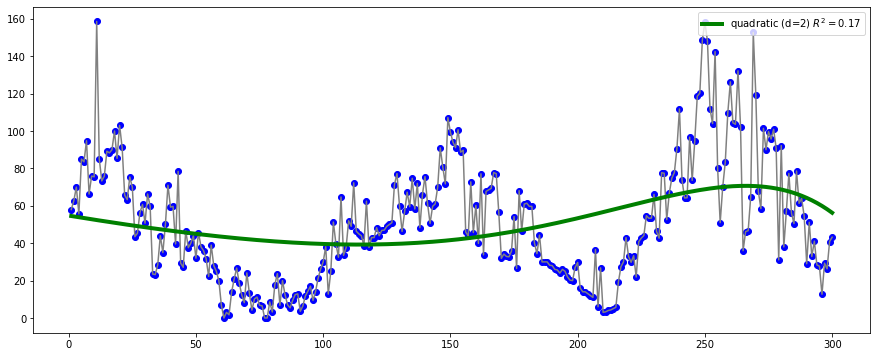

In [26]:
quadratic = PolynomialFeatures(degree = 8)
X_quad = quadratic.fit_transform(X)
scaler = StandardScaler()
scaler.fit(X_quad)
X_quad = scaler.transform(X_quad)
regr.fit(X_quad, y)
y_quad_fit = regr.predict(X_quad)
quad_r2 = r2_score(y, regr.predict(X_quad))
MAE = mean_absolute_error(y, y_quad_fit)
print(f'degree = {best_k}')
print(f'MAE = {min_MAE}')
plt.figure(figsize=(15,6))
plt.plot(X, y, color = 'gray')
plt.scatter(X, y, color = 'b')
plt.plot(X_fit, best_line,
        color = 'green',
        lw = 4,
        linestyle = '-',
        label = 'quadratic (d=2) $R^2={:.2f}$'.format(quad_r2))
plt.legend(loc = 'upper right')

In [28]:
X_SGD_trend = X_fit
y_SGD_trend = y_quad_fit

### Постройте график ВР после процедуры устранения тренда.

#### 1-й метод (МНК)

Удаляем тренд: y - f(t)

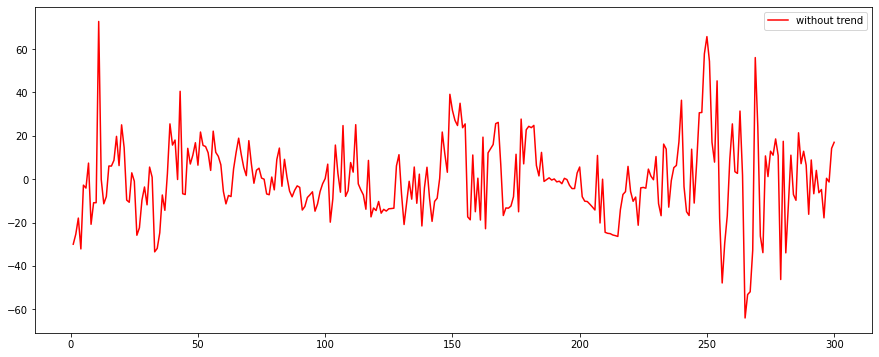

In [29]:
plt.figure(figsize = (15,6))

y_without_trend = y - y_OLS_trend
X = np.arange(1, len(y_without_trend)+1)[:, np.newaxis]

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.legend(loc = 'upper right')

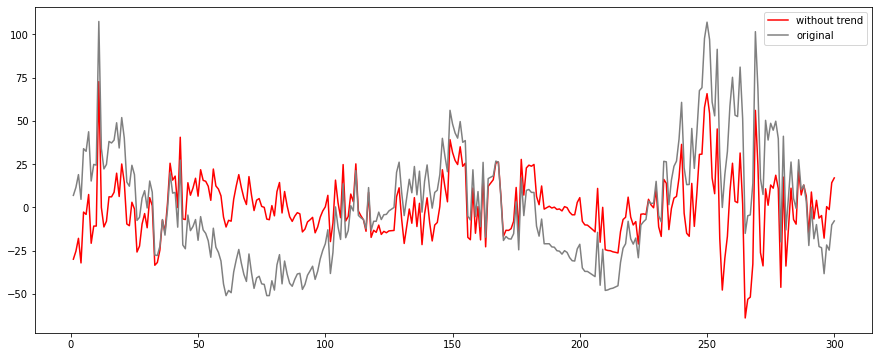

In [30]:
plt.figure(figsize = (15,6))

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.plot(X, y - y.mean(), color = 'gray', label = 'original')

plt.legend(loc = 'upper right')

#### Второй метод (Стахостический градиентный спуск)

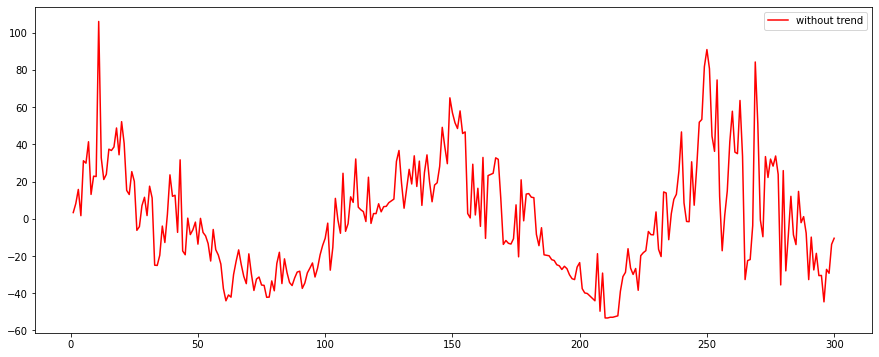

In [31]:
plt.figure(figsize = (15,6))

y_without_trend = y - y_SGD_trend
X = np.arange(1, len(y_without_trend)+1)[:, np.newaxis]

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.legend(loc = 'upper right')

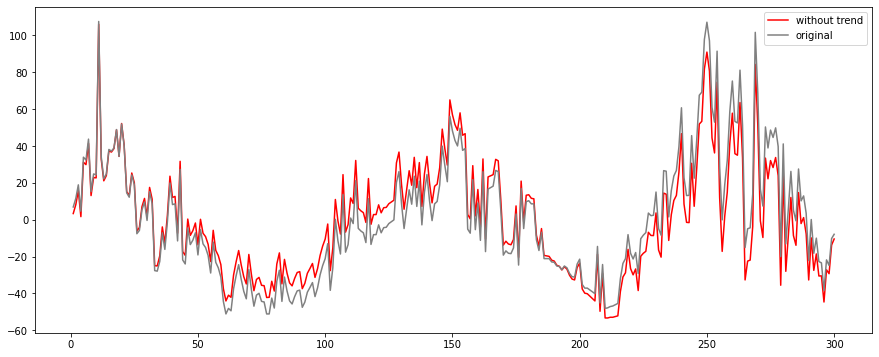

In [32]:
plt.figure(figsize = (15,6))

plt.plot(X, y_without_trend, color = 'red', label = 'without trend')
plt.plot(X, y - y.mean(), color = 'gray', label = 'original')

plt.legend(loc = 'upper right')

### Найдите оценку сезонной компоненты.

#### Первый метод (МНК)

**Оценка сезонной компоненты:**

Период равен году: T = 12

In [33]:
n = len(X)
T = 12
m = (n)/(T)
print(f'm = n/T = {m}')

m = n/T = 25.0


Тогда оценка периодической составляющей:

In [34]:
f = y_OLS_trend
S = []
for t in range(0,T):
    sum_value = 0
    for j in range(int(m)):
        sum_value += y[t+j] - f[t+j]
    S.append(sum_value/m)

Text(0.5, 0, 't')

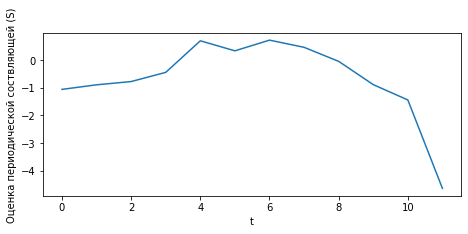

In [35]:
plt.figure(figsize = (7.5,3))
plt.plot(S)
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')

Если сложнить компоненту тренда и сезонную компоненту:
y(t) = u(t) + s(t)<br>
То получился следующая модель

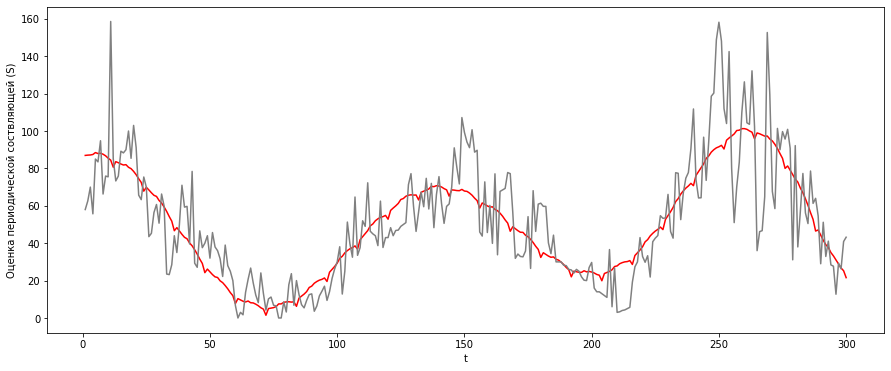

In [36]:
plt.figure(figsize = (15,6))
plt.plot(X, S*int(m) + f, color = 'red', label = 'season')
plt.plot(X, y, color = 'gray', label = 'original')
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')
y_OLS_trend = S*int(m) + f

#### Второй метод (Стахостический градиентный спуск)

Оценка периодической составляющей:

In [37]:
f = y_SGD_trend
S = []
for t in range(0,T):
    sum_value = 0
    for j in range(int(m)):
        sum_value += y[t+j] - f[t+j]
    S.append(sum_value/m)

Text(0.5, 0, 't')

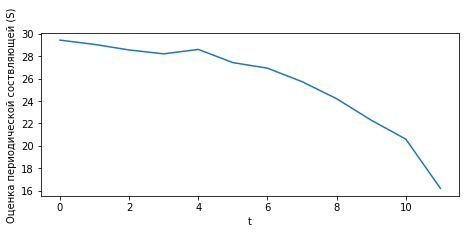

In [38]:
plt.figure(figsize = (7.5,3))
plt.plot(S)
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')

Если сложнить компоненту тренда и сезонную компоненту:
y(t) = u(t) + s(t)<br>
То получился следующая модель

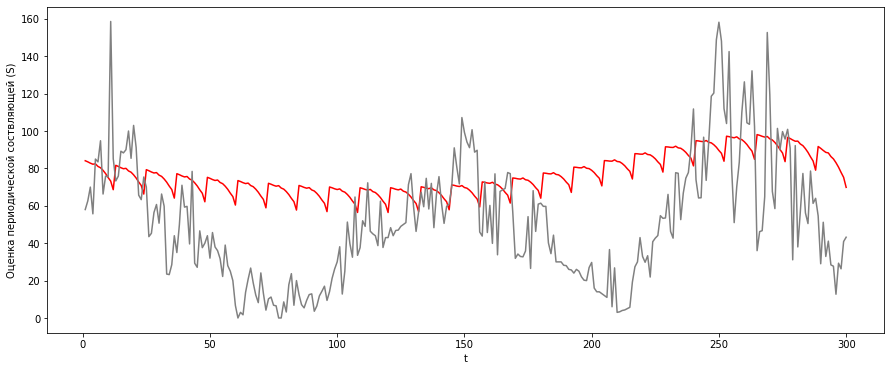

In [39]:
plt.figure(figsize = (15,6))
plt.plot(X, S*int(m) + f, color = 'red', label = 'season')
plt.plot(X, y, color = 'gray', label = 'original')
plt.ylabel('Оценка периодической соствляющей (S)')
plt.xlabel('t')
y_SGD_trend = S*int(m) + f

### Для каждого из методов оценки тренда и сезонной компоненты вычислите остатки и постройте их графики. Исследуйте остатки на случайность по известным вам критериям. 

#### Первый метод (МНК)

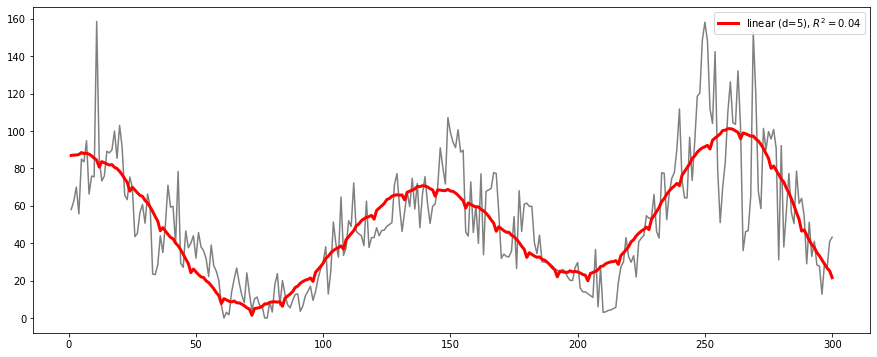

In [40]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_OLS_trend, y_OLS_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')

Text(0, 0.5, 'residuals')

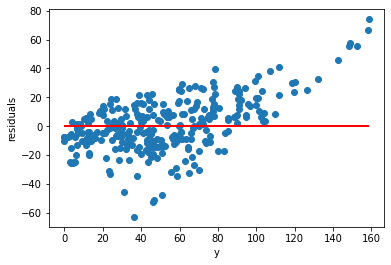

In [41]:
e = y - y_OLS_trend
plt.scatter(y, e)
plt.hlines(xmax=y.max(), xmin=y.min(), y = 0, color = 'red', lw = 2)
plt.xlabel('y')
plt.ylabel('residuals')

Проверим остатки на случаность

Критерий серий основанный на медиане выборки:

In [42]:
e = y - y_OLS_trend
e_series = pd.Series(e)
series_test(e_series)

(False, False)

Оба условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

 Критерий восходящих и нисходящих серий

In [43]:
second_test(e_series)

(False, True)

Не все условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

Тест Дарбина-Уотсона

In [44]:
from statsmodels.stats.stattools import durbin_watson
print(f'Статистика Дарбина-Уотсона: d = {durbin_watson(e)}')

Статистика Дарбина-Уотсона: d = 1.1040305202870782


In [45]:
n = len(y)
print(f'n = {n}')

n = 300


Alpha = 0.05 <br>
d <= 2 <br>
d_lower = 1.785 <br>
d_upper = 1.801 <br>

Вывод: d < d_lower следовательно нулевая гипотеза о случайности остатков отклоняется <br>
Остатки неслучайны. <br>
Модель тренда неадвекватна. <br>

#### Второй метод (Стахостический градиентный спуск)

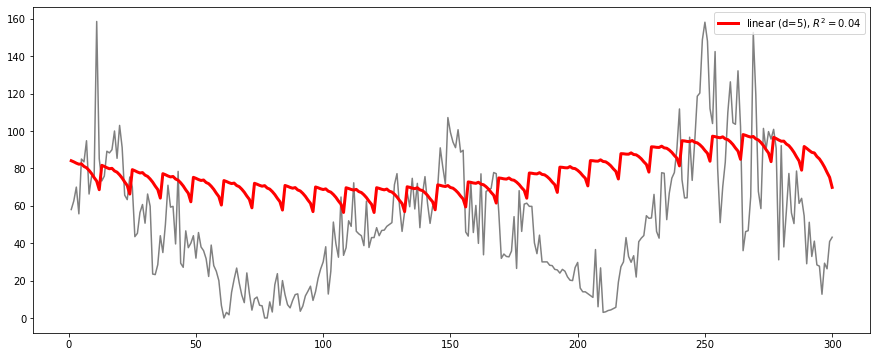

In [46]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_SGD_trend, y_SGD_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')

Text(0, 0.5, 'residuals')

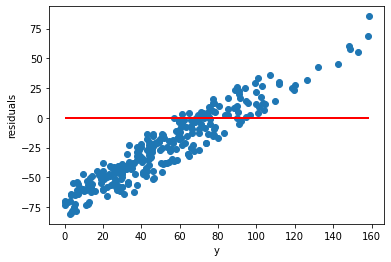

In [47]:
e = y - y_SGD_trend
plt.scatter(y, e)
plt.hlines(xmax=y.max(), xmin=y.min(), y = 0, color = 'red', lw = 2)
plt.xlabel('y')
plt.ylabel('residuals')

Проверим остатки на случаность

Критерий серий основанный на медиане выборки:

In [48]:
e = y - y_OLS_trend
e_series = pd.Series(e)
series_test(e_series)

(False, False)

Условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

Критерий восходящих и нисходящих серий

In [49]:
second_test(e_series)

(False, True)

Не все условия выполняются, следовательно отклоняем гипотезу о случайности остатков. Модель тренда неадекватна.

Тест Дарбина-Уотсона

In [50]:
from statsmodels.stats.stattools import durbin_watson
print(f'Статистика Дарбина-Уотсона: d = {durbin_watson(e)}')

Статистика Дарбина-Уотсона: d = 1.1040305202870782


In [51]:
n = len(y)
print(f'n = {n}')

n = 300


Alpha = 0.05 <br>
d <= 2 <br>
d_lower = 1.785 <br>
d_upper = 1.801 <br>

Вывод: d < d_lower следовательно нулевая гипотеза о случайности остатков отклоняется <br>
Остатки неслучайны. <br>
Модель тренда неадвекватна. <br>

### Постройте прогноз исследуемого показателя y для моментов времени t = 31; 34; 37; 41 для каждого из двух рассматриваемых методов. Отметьте полученные прогнозные значения на исходной диаграмме.

#### Первый метод (МНК)

y(31) = 59.36305169876645
y(34) = 51.790629877559745
y(37) = 46.553583675019574
y(41) = 40.10327235532171


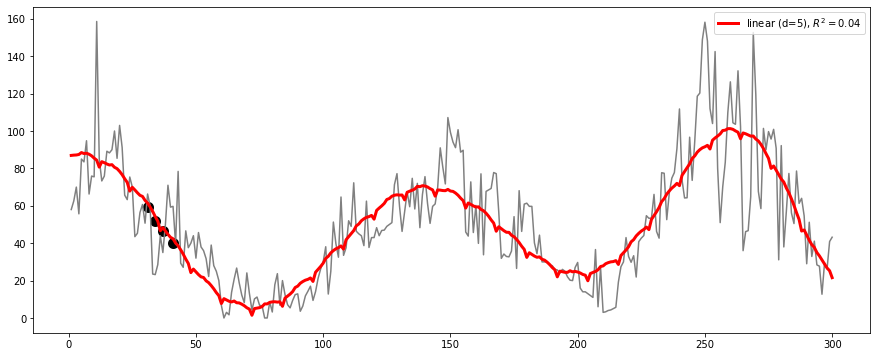

In [52]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_OLS_trend, y_OLS_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')
t = [31, 34, 37, 41]
for i in range(4):
    print(f'y({t[i]}) = {y_OLS_trend[t[i]]}')
plt.scatter(t, y_OLS_trend[t], lw = 5, color = 'black')

#### Второй метод (Стахостический градиентный спуск)

y(31) = 74.34587163181395
y(34) = 68.68746689201494
y(37) = 76.62877335254964
y(41) = 74.33446500947528


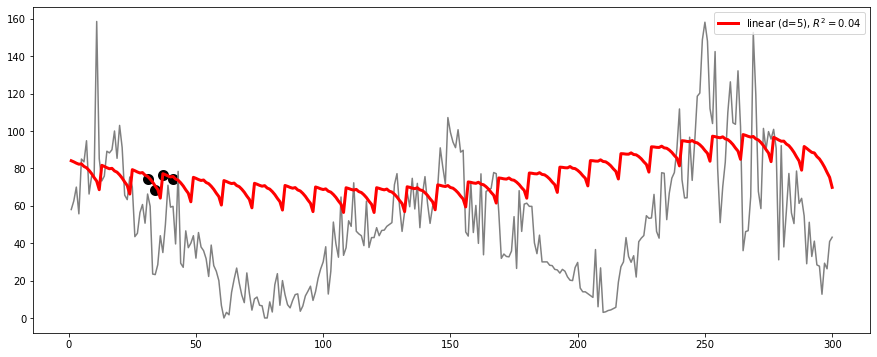

In [53]:
plt.figure(figsize = (15,6))
plt.plot(X, y, color = 'gray')
plt.plot(X_SGD_trend, y_SGD_trend, 
         color = 'red',
         linestyle = '-',
         lw = 3,
         label = 'linear (d=5), $R^2={:.2f}$'.format(linear_r2))
plt.legend(loc = 'upper right')
t = [31, 34, 37, 41]
for i in range(4):
    print(f'y({t[i]}) = {y_SGD_trend[t[i]]}')
plt.scatter(t, y_SGD_trend[t], lw = 5, color = 'black')

### Проведите сглаживание построенного ВР с помощью метода простой скользящей средней, используя три интервала сглаживания: g = 3, g = 4, g = 5.

In [54]:
y = data_train.values
X = np.arange(1, len(y)+1)[:, np.newaxis]

def moving_average(y, g):
    n = len(y)
    y_MA = np.empty(n - (g//2)*2)
    k = 0
    if g%2 == 0:
        p = int(g/2)
        for i in range(0 + p, n - p):
            sum_value = 0
            for j in range(i-p+1, i+p):
                sum_value += y[j]
            sum_value += (y[i-p] + y[i+p])/2
            sum_value = sum_value/(2*p)
            y_MA[k] = sum_value
            k += 1
    else:
        p = int(g//2)
        for i in range(0 + p, n - p):
            sum_value = 0
            for j in range(i-p, i+p+1):
                sum_value += y[j]
            sum_value = sum_value/(2*p + 1)
            y_MA[k] = sum_value
            k += 1  
    return y_MA

### На исходной диаграмме ВР постройте графики остатков.

Text(0, 0.5, 'residuals')

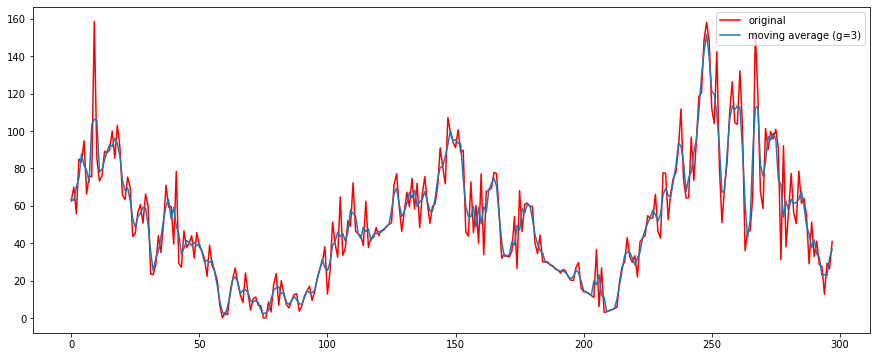

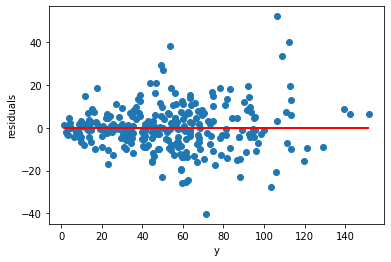

In [55]:
plt.figure(figsize = (15,6))
y_MA_3 = moving_average(y,3)
plt.plot(y[1:-1], color = 'red', label = 'original')
plt.plot(y_MA_3 , label = 'moving average (g=3)')
plt.legend(loc = 'upper right')
y_MA_3_residuals = y[1:-1] - y_MA_3
plt.figure()
plt.scatter(y_MA_3, y_MA_3_residuals)
plt.hlines(xmin=y_MA_3.min(), xmax=y_MA_3.max(),y = 0,  lw = 2, color = 'red')
plt.xlabel('y')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

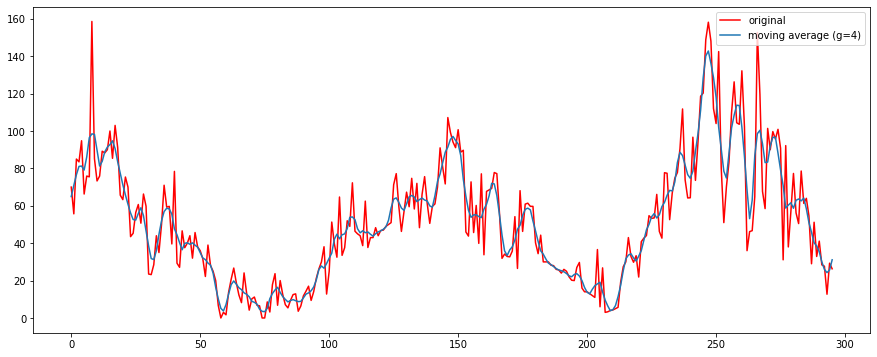

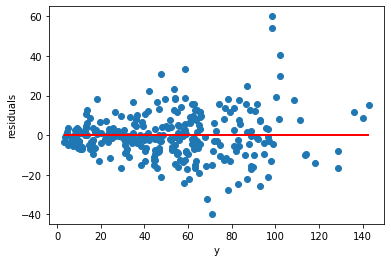

In [56]:
plt.figure(figsize = (15,6))
y_MA_4 = moving_average(y,4)
plt.plot(y[2:-2], color = 'red', label = 'original')
plt.plot(y_MA_4 , label = 'moving average (g=4)')
plt.legend(loc = 'upper right')
y_MA_4_residuals = y[2:-2] - y_MA_4
plt.figure()
plt.scatter(y_MA_4, y_MA_4_residuals)
plt.hlines(xmin=y_MA_4.min(), xmax=y_MA_4.max(),y = 0,  lw = 2, color = 'red')
plt.xlabel('y')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

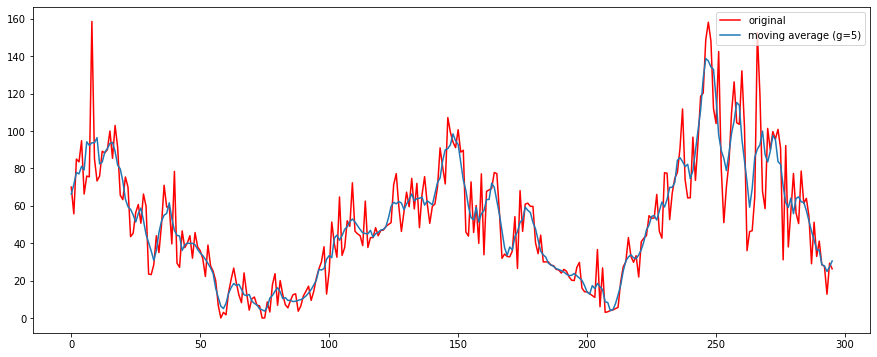

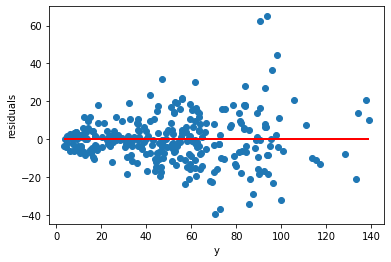

In [57]:
plt.figure(figsize = (15,6))
y_MA_5 = moving_average(y,5)
plt.plot(y[2:-2], color = 'red', label = 'original')
plt.plot(y_MA_5 , label = 'moving average (g=5)')
plt.legend(loc = 'upper right')
y_MA_5_residuals = y[2:-2] - y_MA_5
plt.figure()
plt.scatter(y_MA_5, y_MA_5_residuals)
plt.hlines(xmin=y_MA_5.min(), xmax=y_MA_5.max(),y = 0,  lw = 2, color = 'red')
plt.xlabel('y')
plt.ylabel('residuals')

### Смоделируйте двумерную выборку (xi, yi,), состоящую из 48 наблюдений, по формуле
y_i= α+βx_i+u_i,
u_i= ε_i-ρε_(i-1),i=(1,48) ̅, 
где α и β – коэффициенты из вашей первой лабораторной работы, ρ – параметр, выбираемый произвольно в пределах 0,8≤ρ<1,5; ε_i,i=(1,48) ̅ – выборка из нормального распределения N(0,σ^2).


$$ y_{i} = 34.5538 -0.9500 x_{i} + u_{i} $$
$$ u_{i} = \varepsilon_{i} - \varrho \varepsilon_{i-1} $$

In [58]:
import scipy.stats as sts
mu = 0
sigma = 1

# зададим нормально распределенную случайную величину
norm_rv = sts.norm(loc=mu, scale=sigma)
eps = norm_rv.rvs(size=49)
print(eps)

[ 0.05140867  0.39391815 -0.2056909   2.23545236 -2.32958858 -1.97213411
  1.67559993 -1.74658123 -1.30201832 -0.98721058  0.92602697  1.95029472
  0.42962802 -1.88489943  0.82888322  0.6881807   1.12030468 -0.27973045
  1.52525218 -1.04732933 -1.46499921  0.77220437  1.14937626 -1.35517655
  0.74803862  0.58848223  0.01023562  1.68067301 -0.21503784 -1.83469414
  0.46699556 -0.62226427  1.69521302 -0.00417671 -1.07036745  0.62527549
  0.64065786  0.09354605 -0.27703615 -0.13673898  1.25696969 -0.20519128
  0.94220769 -0.65208753 -0.47454946  1.83698817  0.30179161  0.74534885
 -0.60964314]


In [74]:
# Посчитаем u
rho =1.2
u = [eps[i] - rho*eps[i-1] for i in range(1, 49)]

In [75]:
X = np.arange(1, 49)
y = 34.5538 - 0.95*X + u

### Постройте диаграмму рассеяния.

Text(0, 0.5, 'y')

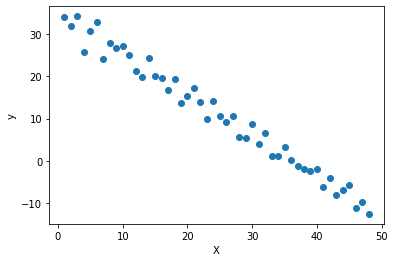

In [62]:
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')

### Постройте соответствующую парную линейную регрессию и вычислите остатки.

In [63]:
X = X[:,np.newaxis]

In [64]:
from sklearn.preprocessing import StandardScaler

In [65]:
len(X)

48

a = 34.622325396817615
b = -0.9542623818843707


Text(0, 0.5, 'residuals')

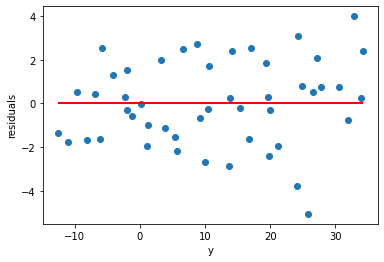

In [66]:
from sklearn.linear_model import LinearRegression
clf_linear = LinearRegression()

clf_linear.fit(X,y)
y_pred = clf_linear.predict(X)
print(f'a = {clf_linear.intercept_}')
print(f'b = {clf_linear.coef_[0]}')
residuals = y - y_pred
plt.scatter(y, residuals)
plt.hlines(xmax=y.max(), xmin=y.min(), y = 0, color = 'red', lw = 2)
plt.xlabel('y')
plt.ylabel('residuals')

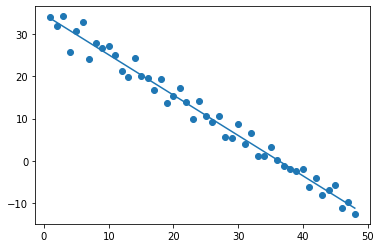

In [67]:
plt.scatter(X, y)
plt.plot(X, y_pred)

In [68]:
mean_absolute_error(y, y_pred)

1.5691309361309118

### Вычислите статистику Дарбина-Уотсона и сделайте вывод о наличии или отсутствии значимой автокорреляции в остатках, воспользовавшись таблицей критических значений распределения Дарбина-Уотсона. 

In [69]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

2.881658752524281

In [70]:
4 - durbin_watson(residuals)

1.118341247475719

In [71]:
n = len(y)
print(f'n = {n}')

n = 48


Alpha = 0.05 <br>
d >= 2 <br>
d_lower = 1.50 <br>
d_upper = 1.58 <br>

Вывод: 4-d < d_lower следовательно нулевая гипотеза о случайности остатков не отклоняется <br>
Значит остатки случайны и автокорреляция отсутвует . <br>

### Вычислите коэффициент автокорреляции первого порядка и сравните его со значением критерия Дарбина-Уотсона.

In [72]:
print(f'Коэффицеиент авторкорреляции первого порядка = {pd.Series(residuals).autocorr(1)}')

Коэффицеиент авторкорреляции первого порядка = -0.4487343950143821


In [73]:
(1-pd.Series(residuals).autocorr(1))*2

2.897468790028764

$$ 2[1 - r(e_{t}, e_{t-1})] = 2.897468790028764 $$

$$ 2.897468790028764 \approx 2.881658752524281 $$